In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from unwrap_error import iono
figsize = [12, 4]

proj_dir = '/Users/yunjunz/data/archives/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

mintpy_dir = os.path.join(proj_dir, 'mintpyOffset')
out_file = os.path.join(mintpy_dir, 'TS_gim_tec.pickle')

# config for GIM TEC data
gim_tec_dir = os.path.join(proj_dir, 'tec_sent1_tracks')
iono_height = 450e3  # height of ionospheric shell in m

Go to directory /Users/yunjunz/data/archives/ChileSenAT149


### 1.1 grab the geometry info

In [2]:
geom_file = os.path.join(mintpy_dir, 'inputs/geometryRadar.h5')
atr = readfile.read_attribute(geom_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
row_c = int(length / 2)
col_c = int(width / 2)
box_c = (col_c, row_c, col_c+1, row_c+1)

# geometry on the ground
head_angle = float(atr['HEADING'])
inc_angle_c = readfile.read(geom_file, datasetName='incidenceAngle', box=box_c)[0][0,0]
lat_c = readfile.read(geom_file, datasetName='latitude', box=box_c)[0][0,0]
lon_c = readfile.read(geom_file, datasetName='longitude', box=box_c)[0][0,0]

# geometry at the ionospheric shell
inc_angle = ut.incidence_angle_ground2iono_shell_along_los(inc_angle_c, iono_height=iono_height)
lat, lon = ut.lalo_ground2iono_shell_along_los(lat_c, lon_c,
                                               inc_angle=inc_angle_c,
                                               head_angle=head_angle,
                                               iono_height=iono_height)

print('heading   angle: {:.1f} deg'.format(head_angle))
print('incidence angle on the ground: {:.1f} deg'.format(inc_angle_c))
print('incidence angle at ionosphere: {:.1f} deg'.format(inc_angle))
print('SAR scene center on the ground in lat/lon: {:.1f}/{:.1f}'.format(lat_c, lon_c))
print('SAR scene center at ionosphere in lat/lon: {:.1f}/{:.1f}'.format(lat, lon))
print('SAR acquisition time UTC: {} hours'.format(float(atr['CENTER_LINE_UTC']) / 3600.))

heading   angle: -13.9 deg
incidence angle on the ground: 39.7 deg
incidence angle at ionosphere: 36.6 deg
SAR scene center on the ground in lat/lon: -21.0/-68.4
SAR scene center at ionosphere in lat/lon: -18.1/-69.2
SAR acquisition time UTC: 23.1075 hours


### 1.2 read GIM TEC and calculate the range delay

In [3]:
## calculate the vertical TEC
ts_file = os.path.join(mintpy_dir, 'timeseriesRg.h5')
date_list_all = timeseries(ts_file).get_date_list()

date_list = []
vtec_total_list = []
vtec_downside_list = []
vtec_topside_list = []
ipp_lat_list = []
ipp_lon_list = []
dist_list = []

for date_str in date_list_all:
    (vtec_total,
     vtec_downside,
     vtec_topside,
     ipp_lat,
     ipp_lon,
     dist) = iono.get_gim_tec_value(gim_tec_dir, date_str, lat, lon, display=False)

    if vtec_total is not None:
        date_list.append(date_str)
        vtec_total_list.append(vtec_total)
        vtec_downside_list.append(vtec_downside)
        vtec_topside_list.append(vtec_topside)
        ipp_lat_list.append(ipp_lat)
        ipp_lon_list.append(ipp_lon)
        dist_list.append(dist)



read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20150624.txt.dt
distance to nearest TEC obs: 1.8 deg (199 km)
ERROR: no file found for 20150811 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20150811.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20150928.txt.dt
distance to nearest TEC obs: 1.4 deg (153 km)
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20151022.txt.dt
distance to nearest TEC obs: 4.0 deg (427 km)
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20151115.txt.dt
distance to nearest TEC obs: 2.4 deg (263 km)
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20151209.txt.dt
distance to nearest TEC obs: 0.5 deg (50 km)
read JPL GIM TEC data from file: /

### 2. save to pickle file

In [6]:
# gather all into gim_tec dict
gim_tec = {}
gim_tec['date'] = np.array(date_list)
gim_tec['time'] = np.array(ptime.date_list2vector(date_list)[0])
gim_tec['vtec_total'] = np.array(vtec_total_list)
gim_tec['vtec_downside'] = np.array(vtec_downside_list)
gim_tec['vtec_topside'] = np.array(vtec_topside_list)
gim_tec['ipp_lat'] = np.array(ipp_lat_list)
gim_tec['ipp_lon'] = np.array(ipp_lon_list)
gim_tec['distance'] = np.array(dist_list)

## calculate the predicted range delay
# L-band: 1.2575 GHz (ALOS2)
# C-band: 5.405 GHz (Sentinel-1)
gim_tec['range_delay_tec_total_Sen']      = iono.vtec2range_delay(gim_tec['vtec_total'],    inc_angle, freq=5.405e9)
gim_tec['range_delay_tec_downside_Sen']   = iono.vtec2range_delay(gim_tec['vtec_downside'], inc_angle, freq=5.405e9)
gim_tec['range_delay_tec_total_Alos2']    = iono.vtec2range_delay(gim_tec['vtec_total'],    inc_angle, freq=1.2575e9)
gim_tec['range_delay_tec_downside_Alos2'] = iono.vtec2range_delay(gim_tec['vtec_downside'], inc_angle, freq=1.2575e9)

## save to file
with open(out_file, 'wb') as f:
    pickle.dump(gim_tec, f)
    print('save data to file: {}'.format(out_file))

save data to file: /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_gim_tec.pickle


### 3. plot

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_gim_tec.png


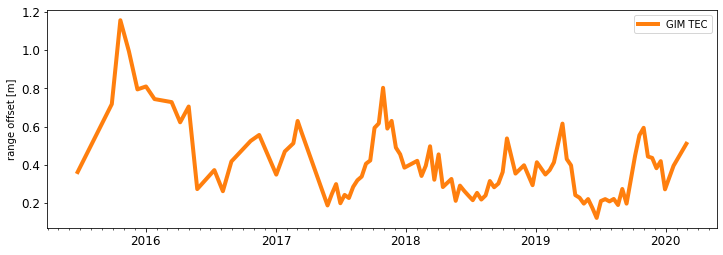

In [7]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(gim_tec['time'], gim_tec['range_delay_tec_total_Sen'], linewidth=4, color='C1', label='GIM TEC')
pp.auto_adjust_xaxis_date(ax, times, every_year=1, buffer_year=None)
ax.set_ylabel('range offset [m]')
plt.legend()

# output
out_fig = os.path.join(mintpy_dir, 'TS_gim_tec.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()